<a href="https://colab.research.google.com/github/doubi-xu/Political-Ideology-and-Customer-Feedback-Behaviors/blob/main/BERTforFEEDBACK_Prolific03102024_addclassweights_crossvalidation10092024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 79.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [ ]:
pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 23.2 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.34.2
    Uninstalling accelerate-0.34.2:
      Successfully uninstalled accelerate-0.34.2


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import os

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

path = '/content/drive/My Drive/carsdotcom/ACSI_Prolific.xlsx'
data = pd.read_excel(path)

Mounted at /content/drive


In [ ]:
data.head()

,POLITICS,INDUSTRY,YEAR,VBEST,VWORST,Feedback,Length,sample,RN,Group,...,modedown,moderandom,mean,Qualtrics_Question,Industry,Best,Wost,mode_mean,number of modes,ORDER
0,Moderate or Middle of the Road,Airlines (scheduled),2017,price,service,price service,12,1,0.637746,1.0,...,1.0,1.0,2.0,QID2,Airline,price,service,1.0,1.0,1
1,Moderate or Middle of the Road,Airlines (scheduled),2017,Service,Nothing,Service Nothing,14,1,0.237864,1.0,...,1.0,1.0,1.0,QID3,Airline,Service,Nothing,1.0,1.0,2
2,Slightly Conservative,Airlines (scheduled),2018,Reliable,Quality,Reliable Quality,15,1,0.581356,1.0,...,1.0,1.0,2.0,QID4,Airline,Reliable,Quality,1.0,1.0,3
3,Extremely Liberal,Airlines (scheduled),2018,i like it,i like it,i like it i like it,18,1,0.235317,1.0,...,1.0,1.0,1.0,QID5,Airline,i like it,i like it,1.0,1.0,4
4,Slightly Liberal,Airlines (scheduled),2019,Good price.,Cheaper.,Good price. Cheaper.,19,1,0.514220,1.0,...,1.0,1.0,2.0,QID6,Airline,Good price.,Cheaper.,1.5,2.0,5


In [ ]:
# Dropping rows with any missing values in the text and label columns from the full dataset 'data'
clean_data = data.dropna(subset=['Feedback', 'mean'])

# Displaying the shape of the original and cleaned datasets to understand how much data remains after cleaning
original_shape = data.shape
clean_shape = clean_data.shape

original_shape, clean_shape

((13425, 23), (1172, 23))

In [ ]:
#Calculate Class Weights
from sklearn.utils.class_weight import compute_class_weight

# Assuming 'Y3_moderandom' is your target variable
class_labels = np.unique(clean_data['mean'])
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=clean_data['mean'])

# Convert class weights to a dictionary for easy use
weight_dict = {class_label: weight for class_label, weight in zip(class_labels, class_weights)}
print(weight_dict)

{0.0: 0.37088607594936707, 1.0: 6.335135135135135, 2.0: 1.0703196347031962, 3.0: 1.154679802955665, 4.0: 2.893827160493827}


In [ ]:
# Updated tokenize_function to handle the 'Feedback' column directly
def revised_tokenize_function(examples):
    # Ensure the input is in list format for Feedback
    feedback = examples["Feedback"] if isinstance(examples["Feedback"], list) else [examples["Feedback"]]

    # Tokenize
    return tokenizer(feedback, padding="max_length", truncation=True)

# Testing the revised function with a single row of data
# Assuming 'Feedback' contains a combination of 'VBEST' and 'VWORST' information
sample_data = {"Feedback": "Excellent service Long waiting times"}
print(revised_tokenize_function(sample_data))


{'input_ids': [[101, 6581, 2326, 2146, 3403, 2335, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Tokenize the text
tokenized_datasets = clean_data.apply(lambda x: revised_tokenize_function(x), axis=1)

In [ ]:
# Preparing dataset for BERT
class FeedbackDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx])) # Ensure labels are integers
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
# NOT USE
# Splitting the data into training and validation sets
train_dataset, val_dataset = train_test_split(clean_data, test_size=0.1)

# Creating dataset objects
train_dataset = FeedbackDataset(revised_tokenize_function(train_dataset.to_dict('list')), train_dataset['mean'].tolist())
val_dataset = FeedbackDataset(revised_tokenize_function(val_dataset.to_dict('list')), val_dataset['mean'].tolist())

# Load a pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=6)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Model with weighted loss function
class BertForSequenceClassificationCustom(BertForSequenceClassification):
    # Override the method to include class weights
    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and logits
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # Define weighted loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(weight_dict.values())).cuda())
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5)
X = clean_data['Feedback']
y = clean_data['mean']

fold_results = []
all_confusion_matrices = []
all_roc_aucs = []

In [ ]:
# Define metrics function
def compute_metrics(p):
    predictions = p.predictions.argmax(-1)
    labels = p.label_ids
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


Training fold 1...



model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.831900
20,1.798800
30,1.691700
40,1.581700
50,1.549800
60,1.343200
70,1.271900
80,1.168200
90,1.151400
100,0.897900


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training fold 2...



Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.520200
20,1.447200
30,1.473200
40,1.403700
50,1.399800
60,1.249200
70,1.301200
80,1.152900
90,1.241400
100,0.969200



Training fold 3...



Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.576300
20,1.476800
30,1.414700
40,1.371300
50,1.354700
60,1.426800
70,1.285600
80,1.144600
90,1.060900
100,1.079200


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training fold 4...



Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.545100
20,1.497100
30,1.415700
40,1.386800
50,1.332000
60,1.349100
70,1.209000
80,1.117300
90,1.046500
100,0.932900



Training fold 5...



Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,1.549500
20,1.508500
30,1.436800
40,1.408000
50,1.302300
60,1.352000
70,1.213900
80,1.146000
90,1.084800
100,1.052200


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)



Cross-Validation Results: {'accuracy': 0.7610947444989999, 'precision': 0.7548847754147925, 'recall': 0.7610947444989999, 'f1': 0.7466978039711156, 'mae': 0.269645390070922, 'mse': 0.3311256592107656, 'roc_auc': nan}


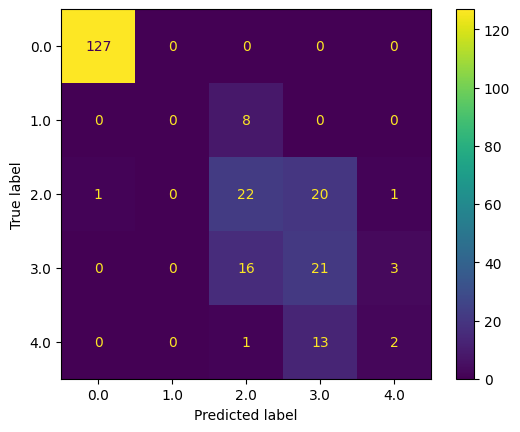

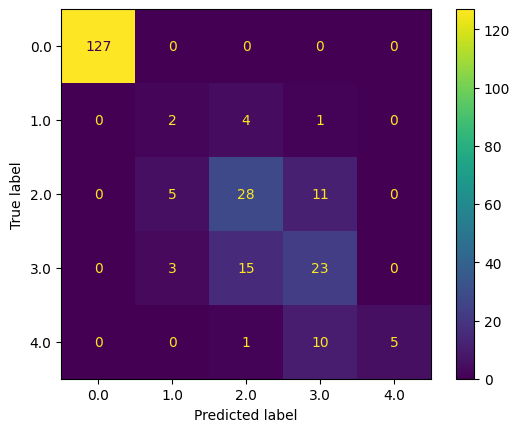

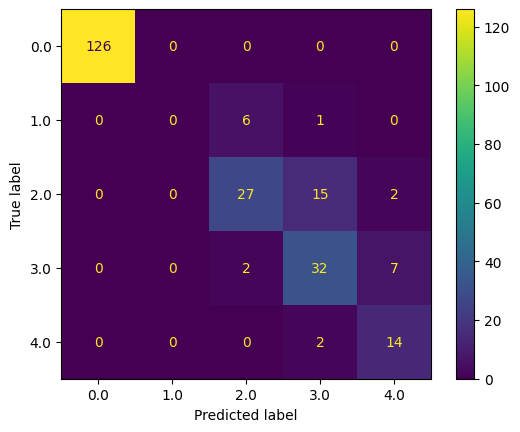

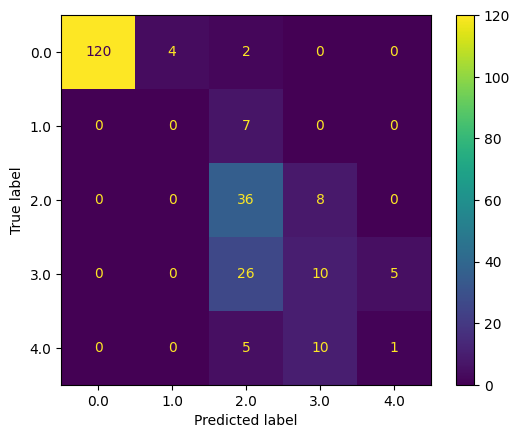

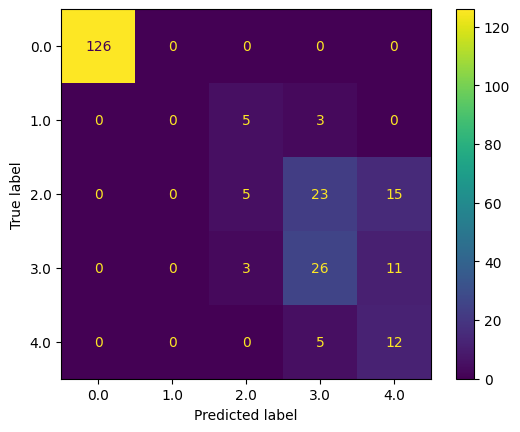

In [ ]:
# Cross-validation loop - 10092024
for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"\nTraining fold {fold + 1}...\n")

    # Tokenize the train and validation sets
    train_texts = clean_data.iloc[train_idx]['Feedback'].tolist()
    train_labels = clean_data.iloc[train_idx]['mean'].tolist()
    val_texts = clean_data.iloc[val_idx]['Feedback'].tolist()
    val_labels = clean_data.iloc[val_idx]['mean'].tolist()

    train_encodings = tokenizer(train_texts, padding=True, truncation=True, max_length=512)
    val_encodings = tokenizer(val_texts, padding=True, truncation=True, max_length=512)

    # Prepare datasets for this fold
    train_dataset = FeedbackDataset(train_encodings, train_labels)
    val_dataset = FeedbackDataset(val_encodings, val_labels)

    # Initialize model for each fold
    model = BertForSequenceClassificationCustom.from_pretrained('bert-base-uncased', num_labels=len(class_labels))

    # Define training arguments
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=8,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=10,
        learning_rate=5e-5
    )

    # Define Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

    # Train the model for the current fold
    trainer.train()

    # Get predictions on validation data
    predictions_output = trainer.predict(val_dataset)
    predictions = predictions_output.predictions.argmax(-1)
    labels = predictions_output.label_ids

    # Calculate accuracy, precision, recall, f1 for this fold
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    # Calculate MAE and MSE
    mae = mean_absolute_error(labels, predictions)
    mse = mean_squared_error(labels, predictions)

    # Confusion Matrix for this fold
    cm = confusion_matrix(labels, predictions)
    all_confusion_matrices.append(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()  # Display confusion matrix for each fold

    # ROC-AUC for this fold (multiclass)
    try:
        roc_auc = roc_auc_score(labels, predictions_output.predictions, multi_class='ovr')
        all_roc_aucs.append(roc_auc)
    except ValueError:
        roc_auc = "Undefined"  # Handle cases where ROC-AUC cannot be computed

    # Append fold results
    fold_results.append({
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'mae': mae,
        'mse': mse,
        'roc_auc': roc_auc
    })

# Average results across all folds
avg_results = {
    'accuracy': np.mean([result['accuracy'] for result in fold_results]),
    'precision': np.mean([result['precision'] for result in fold_results]),
    'recall': np.mean([result['recall'] for result in fold_results]),
    'f1': np.mean([result['f1'] for result in fold_results]),
    'mae': np.mean([result['mae'] for result in fold_results]),
    'mse': np.mean([result['mse'] for result in fold_results]),
    'roc_auc': np.mean([result['roc_auc'] for result in all_roc_aucs if result != "Undefined"])  # Avoid undefined ROC-AUC scores
}

# Display averaged cross-validation results
print(f"\nCross-Validation Results: {avg_results}")

Below are old content!

In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

class BertForSequenceClassificationCustom(BertForSequenceClassification):
    # Override the method to include class weights
    def compute_loss(self, model, inputs, return_outputs=False):
        # Extract labels and logits
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # Define weighted loss
        loss_fct = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(weight_dict.values())).cuda())
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Initialize your model
model = BertForSequenceClassificationCustom.from_pretrained('bert-base-uncased', num_labels=len(class_labels))

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {'accuracy': accuracy_score(p.label_ids, p.predictions.argmax(-1))},
)

trainer.train()

Some weights of BertForSequenceClassificationCustom were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
10,1.767200
20,1.743000
30,1.767100
40,1.649300
50,1.510400
60,1.417900
70,1.240600
80,1.100300


In [ ]:
# Define a function to predict new examples
def predict_new(data_to_predict):
    predictions = trainer.predict(FeedbackDataset(revised_tokenize_function(data_to_predict.to_dict('list')), data_to_predict['mean'].tolist()))
    return [int(prediction.argmax()) for prediction in predictions.predictions]

In [ ]:
# Dropping rows with any missing values in the VBEST, VWORST columns from the full dataset 'data'
data_nomissing = data.dropna(subset=['Feedback'])

# Displaying the shape of the original and cleaned datasets to understand how much data remains after cleaning
original_shape = data.shape
data_nomissing_shape = data_nomissing.shape

original_shape, data_nomissing_shape

In [ ]:
class FeedbackDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = torch.tensor(int(self.labels[idx]) if not pd.isna(self.labels[idx]) else -1)
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

def predict_new(data_to_predict):
    # Assuming data_to_predict has the same format as the original data
    tokenized_data = revised_tokenize_function(data_to_predict.to_dict('list'))  # Ensure this function tokenizes the input data appropriately
    dataset = FeedbackDataset(tokenized_data)  # No labels provided during prediction
    predictions = trainer.predict(dataset)
    return [int(prediction.argmax()) for prediction in predictions.predictions]

# Predict on the entire dataset (assuming 'predict_new' and 'revised_tokenize_function' are correctly defined)
data_nomissing['predicted'] = predict_new(data_nomissing)



In [ ]:
# Export the updated dataframe to an Excel file
output_file_path = './predicted_usefulness_mean_csl.xlsx'
data_nomissing.to_excel(output_file_path, index=False)

output_file_path

'./predicted_usefulness_mean_csl.xlsx'